<a href="https://colab.research.google.com/github/MrCelestial/GAN-MNIST/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 49.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
# First, check if GPU is available
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import imageio
import os

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 784  # 28x28 pixels
num_epochs = 100
batch_size = 128  # Increased for GPU
lr = 0.0002

# Directory to store generated images
os.makedirs("generated_images", exist_ok=True)

Using device: cuda


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]


In [6]:
# Initialize networks and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Lists to store losses for plotting
g_losses = []
d_losses = []

In [10]:
def train_gan():
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.view(-1, image_dim).to(device)

            # Labels for real and fake images
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")
                generate_images(num_images=16, epoch=epoch, step=len(dataloader))


def generate_images(num_images=16, epoch=None, step=None, save=True):
    generator.eval()  # Set generator to evaluation mode
    if save: os.makedirs('generated_images', exist_ok=True)

    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = generator(z).cpu().view(-1, 28, 28)  # Assuming MNIST (28x28)

        # Define grid size dynamically
        cols = int(np.ceil(np.sqrt(num_images)))
        rows = int(np.ceil(num_images / cols))

        fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
        axes = np.array(axes).flatten()

        for i, ax in enumerate(axes):
            if i < num_images:
                ax.imshow(generated_images[i], cmap='gray')
            ax.axis('off')

        plt.tight_layout()

        if save and epoch is not None and step is not None:
            filename = f"generated_images/epoch_{epoch:03d}_step_{step:04d}.png"
            plt.savefig(filename)
            # Ensure the image is added to the list for GIF creation
            plt.close()  # Add this line to close the figure,
            # prevent memory leaks and avoid error like image is too large to save

        display.clear_output(wait=True)
        plt.show()


    generator.train()  # Set back to training mode


In [8]:
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()


# Create GIF after training
def create_gif(output_filename="gan_training_progress.gif"):
    images = []
    for filename in sorted(os.listdir("generated_images")):
        if filename.endswith(".png"):
            images.append(imageio.v2.imread(f"generated_images/{filename}"))

    imageio.mimsave(output_filename, images, duration=0.5)
    print(f"GIF saved as {output_filename}")

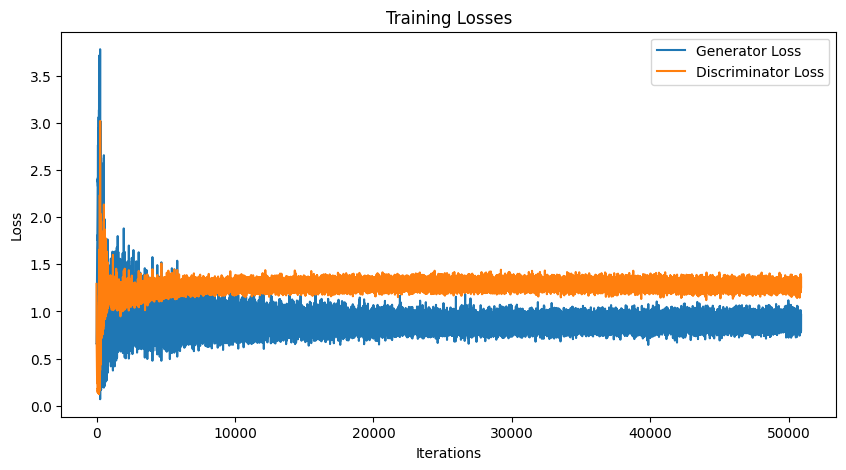

GIF saved as gan_training_progress.gif


In [11]:
if __name__ == "__main__":
    num_epochs = 100  # Adjust as needed
    train_gan()
    plot_losses()
    create_gif()